### Character-Level Language Model

This notebook contains a generative model working at the level of characters.


In [48]:
import numpy as np
from numpy.random import randint,rand,seed,normal,permutation,choice

import string
import math

import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader



# from torchsummary import summary                   # must install using pip install torchsummary

In [49]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = 'drive/MyDrive/CS505 Datasets/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load a text file. We chose a poem, to see how it did with line breaks.  

In [50]:

with open(data_dir+"Milton_Paradise_Lost.txt", "r") as text_file:
    text = text_file.read()

text[:100]

"Of Man's first disobedience, and the fruit\nOf that forbidden tree whose mortal taste\nBrought death i"

No normalization will be performed, however,
we will run out of RAM if we attempt to
use the entire poem as data. We have chosen
here to use 10K characters, out of a total
of

In [51]:
print(f"Text is {len(text)} characters long.")

size = 10000

text = text[:size]

Text is 456475 characters long.


Next we figure out how many distinct characters there are in the text; this
will be what is generated at each step of the generation.

In [52]:
chars_in_text = sorted(list(set(text)))

num_chars = len(chars_in_text)

print(f'There are {num_chars} characters in the text.')


print(f'Character set: {chars_in_text}.')


There are 62 characters in the text.
Character set: ['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'].


In [53]:
# Create functions mapping characters to integers and back

def char2int(c):
    return chars_in_text.index(c)

def int2char(i):
    return chars_in_text[i]

As we're going to predict the next character in the sequence at each time step, we'll have to divide each sentence into

- Input data
    - The last input character should be excluded as it does not need to be fed into the model
- Target/Ground Truth Label
    - One time-step ahead of the Input data as this will be the "correct answer" for the model at each time step corresponding to the input data

The sample length is a critical parameter which tells us how much of the source data to ingest at each training step.  You might want to play around with this as one of the hyperparameters.

In [54]:
sample_len = 100

# Creating lists that will hold our input and target sample sequences

input_seq_chars = []
target_seq_chars = []

for k in range(len(text)-sample_len+1):

    # Remove last character for input sequence
    input_seq_chars.append(text[k:k+sample_len-1])

    # Remove firsts character for target sequence
    target_seq_chars.append(text[k+1:k+sample_len])

for i in range(5):
    print(f'Input sequence:\n{input_seq_chars[i]}')
    print(f'Target sequence:\n{target_seq_chars[i]}')
    print()


Input sequence:
Of Man's first disobedience, and the fruit
Of that forbidden tree whose mortal taste
Brought death 
Target sequence:
f Man's first disobedience, and the fruit
Of that forbidden tree whose mortal taste
Brought death i

Input sequence:
f Man's first disobedience, and the fruit
Of that forbidden tree whose mortal taste
Brought death i
Target sequence:
 Man's first disobedience, and the fruit
Of that forbidden tree whose mortal taste
Brought death in

Input sequence:
 Man's first disobedience, and the fruit
Of that forbidden tree whose mortal taste
Brought death in
Target sequence:
Man's first disobedience, and the fruit
Of that forbidden tree whose mortal taste
Brought death int

Input sequence:
Man's first disobedience, and the fruit
Of that forbidden tree whose mortal taste
Brought death int
Target sequence:
an's first disobedience, and the fruit
Of that forbidden tree whose mortal taste
Brought death into

Input sequence:
an's first disobedience, and the fruit
Of that f

Now we can convert our input and target sequences to sequences of integers instead of characters by mapping them using the functions we created above. This will allow us to one-hot-encode our input sequence later.

In [55]:
input_seq = []
target_seq = []

for i in range(len(input_seq_chars)):
    input_seq.append( [char2int(ch) for ch in input_seq_chars[i]])
    target_seq.append([char2int(ch) for ch in target_seq_chars[i]])

print(input_seq[0])

[27, 41, 1, 25, 36, 49, 4, 54, 1, 41, 44, 53, 54, 55, 1, 39, 44, 54, 50, 37, 40, 39, 44, 40, 49, 38, 40, 7, 1, 36, 49, 39, 1, 55, 43, 40, 1, 41, 53, 56, 44, 55, 0, 27, 41, 1, 55, 43, 36, 55, 1, 41, 50, 53, 37, 44, 39, 39, 40, 49, 1, 55, 53, 40, 40, 1, 58, 43, 50, 54, 40, 1, 48, 50, 53, 55, 36, 47, 1, 55, 36, 54, 55, 40, 0, 14, 53, 50, 56, 42, 43, 55, 1, 39, 40, 36, 55, 43, 1]


In [56]:
# convert an integer into a one-hot encoding of the given size (= number of characters)
def int2OneHot(X,size):

    def int2OneHot1(x,size=10):
        tmp = np.zeros(size)
        tmp[int(x)] = 1.0
        return tmp

    return np.array([ int2OneHot1(x, size) for x in X ]).astype('double')

int2OneHot( np.array([ 2,3,1,2,3,4 ]),10)

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [57]:
# do the same thing, but for a list/array of integers

def seq2OneHot(seq,size):
    return np.array([ int2OneHot(x, size) for x in seq ])

seq2OneHot( np.array([[ 2,3,1,2,3,4 ],[ 2,3,1,2,3,4 ],[ 2,3,1,2,3,4 ]]),10)

array([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])

In [58]:
# Convert our input sequences to one-hot form

input_seq = seq2OneHot(input_seq,size=num_chars)
input_seq.shape

(9901, 99, 62)

In [59]:
# Convert our target sequences to one-hot form

target_seq = seq2OneHot(target_seq,size=num_chars)
target_seq.shape

(9901, 99, 62)

Since we're done with all the data pre-processing, we can now move the data from numpy arrays to tensors.

In [60]:
input_seq = torch.Tensor(input_seq).type(torch.DoubleTensor)
target_seq = torch.Tensor(target_seq).type(torch.DoubleTensor)

Now we will build a data loader to manage the batching.

In [61]:
class Basic_Dataset(Dataset):

    def __init__(self, X,Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    # return a pair x,y at the index idx in the data set
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

ds = Basic_Dataset(input_seq,target_seq)

ds.__len__()

9901

Batch size is a hyperparameter that will mostly determine how efficiently you can process the data on a GPU.

In [62]:
batch_size = 128

data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True)


Check if a GPU is available and use it if it is.

In [63]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


The model will use an LSTM layer and a single linear layer to produce a softmax
of the next character. Various hyperparameters can be chosen to modify this
model.  A messy detail is that two vectors, h0 and c0, have to be created for the hidden state in the LSTM layer (these correspond to the two connections
shown in lecture for an LSTM neuron to send to itself in the next time step).  

In [64]:
from os import device_encoding
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,dropout):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers,dropout=dropout,batch_first=True)
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size)

    def forward(self, x):

        hidden_state_size = x.size(0)

        x = x.to(torch.double)

        h0 = torch.zeros(self.n_layers,hidden_state_size,self.hidden_dim).double().to(device)
        c0 = torch.zeros(self.n_layers,hidden_state_size,self.hidden_dim).double().to(device)

        self.lstm = self.lstm.double()

        self.fc1 = self.fc1.double()

        # Passing in the input and hidden state into the model and obtaining outputs
        out, (hx,cx) = self.lstm(x, (h0,c0))

        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc1(out)

        return out



Next, we instantiate the model with its hyperparameters, all of which can be
changed.

In [65]:
# Instantiate the model with hyperparameters

model = Model(input_size=num_chars, output_size=num_chars, hidden_dim=256, n_layers=1,dropout=0.0)

print(model)

model = model.double().to(device)

# Define Loss, Optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0)



Model(
  (lstm): LSTM(62, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=62, bias=True)
)


The following is a minimal training loop. We just track the loss, since accuracy
is not the point of a generative model.

However, overfitting is very much a problem. You will see that overfitting has occurred when you give as prompt a prefix of the text (say the first line) and in generation it just spits out the text (which it has memorized).

100%|██████████| 10/10 [01:54<00:00, 11.45s/it]


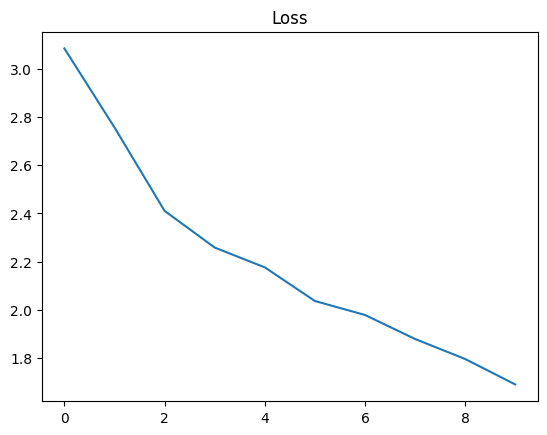

In [66]:
num_epochs = 10

losses = []

model.train()

for epoch in tqdm(range(num_epochs)):

    for input_seq_batch,target_seq_batch in data_loader:
        input_seq_batch = input_seq_batch.to(device)
        target_seq_batch = target_seq_batch.to(device)
        optimizer.zero_grad()
        target_seq_hat = model(input_seq_batch)
        loss = loss_fn(target_seq_hat,target_seq_batch.view(-1,num_chars))
        loss.backward()
        optimizer.step()

    losses.append(loss.item())


plt.title('Loss')
plt.plot(losses)

The temperature of a softmax function will determine  the relative strength of different probabilities:
- As temperature approaches 0, distribution approaches a one-hot with 1 for the max
- As temperature increases, it approaches a uniform distribution

Generally we want to emphasize the higher probabilities, so we choose
a reasonably low temperature.

In [67]:

def softmax_with_temperature(vec, temperature):
    sum_exp = sum(math.exp(x/temperature) for x in vec)
    return [math.exp(x/temperature)/sum_exp for x in vec]

print("Example of softmax with temperature.")
dist = [0.1, 0.3, 0.6]
print('distribution:',dist)
print(softmax_with_temperature(dist,0.01))
print(softmax_with_temperature(dist,0.1))
print(softmax_with_temperature(dist,0.2))
print(softmax_with_temperature(dist,0.3))
print(softmax_with_temperature(dist,1))
print(softmax_with_temperature(dist,10))

Example of softmax with temperature.
distribution: [0.1, 0.3, 0.6]
[1.9287498479637375e-22, 9.3576229688393e-14, 0.9999999999999064]
[0.006377460922442302, 0.04712341652466416, 0.9464991225528936]
[0.06289001324586753, 0.1709527801977903, 0.7661572065563421]
[0.12132647558421489, 0.23631170657656433, 0.6423618178392208]
[0.2583896517379799, 0.3155978333128144, 0.4260125149492058]
[0.3255767455856355, 0.3321538321280155, 0.3422694222863489]


Choose a temperature and predict the next character, given a prompt of arbitrary length.

In [68]:
temperature = 0.3

def predict(model, ch):

    # only look at last sample_len - 1 characters

    ch = ch[-(sample_len - 1):]

    # One-hot encoding our input to fit into the model
    ch = np.array([char2int(c) for c in ch])
    ch = np.array([int2OneHot(ch, num_chars)])
    ch = torch.from_numpy(ch).to(device)

    out = model(ch)

    # take the probability distribution of the last character in the sequence produced by the model
    prob = softmax_with_temperature(out[-1],temperature)

    # Choosing a character based on the probability distribution, with temperature
    char_ind = choice(list(range(num_chars)), p=prob)

    return int2char(char_ind)

predict(model,"Of man's first disobedience, and the fruit o")

'n'

Now take a prompt and iterate the previous prediction a specified number of times.

Prompt is generally taken to be a long sequence randomly selected from the text. You can also try a sequence of words similar to those in the text, but not an exact sequence. It does not have to be the exact length of the data sequences. However, very short prompts tend not to work as well.

In [69]:
def sample(model, out_len, start):
    model.eval() # eval mode
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for ii in range(size):
        char = predict(model, chars)
        chars.append(char)

    return ''.join(chars)

Now we will run our model, but with the parameters we have chosen, and
10 epochs, you can see that it is getting some idea of words and lines, but
it doesn't look like an English poem!

Run this for another 100 epochs, and observe that at that point,
the network will have simply memorized the poem!

In [71]:
print(sample(model, 1000, "Of Man's first disobedience, and the fruit"))

Of Man's first disobedience, and the fruit ros ore thall sus ingeres the store he preat hes pare,
He veint of the gerat on the flaid the vinged of Heaven the wath of the gorthall in served on the gromithe firce sedpent his whale, and will his grong of Heaven on and will his from the prot the tho ders and cengen,
With hese and rought force his fire,
And simed tout for sowe,
That whot ender st of the geall the ing hinger and ranger
Th the his the farl se and rus ind and sure seall
The force of the sore that for hised
And with upmighto formte of the gore ther th of the seaven on the grom the farl seand sulled the the the his dering of Hian, whather th of beis and cous reaven he pering of the dere thers his fired
That with of reaven on the derich and righty stored the the the flor the vence the the sing the bort of Heaven on and compinise, and his pire,
And his om the Alill nised the serce on the derat of Heaven se pint,
And cous ffre stound he pires
And th ur poreid de and sure dain the s